In [302]:
import pandas as pd
import math
import warnings
warnings.filterwarnings("ignore")

#data
data = pd.read_csv('./global.csv')
print(data.shape)


#Goal
# imputation of data
# Find features that best represent Value_co2_emissions_kt_by_country (feature selection)
# Create a model that predicts Value_co2_emissions_kt_by_country for each Regressor (Lasso, Ridge, RandomForest)
# Determine threshold and one hot encode Value_co2_emissions_kt_by_country
# Classify new binary labels

(3649, 21)


In [303]:
#Data Preprocessing 

columns = data.select_dtypes(exclude=['object'])

dropped_columns = ["Year","Value_co2_emissions_kt_by_country", "Longitude", "Latitude"]

imputed_data = data.drop(["Density\\n(P/Km2)", "Longitude", "Latitude"], axis=1)

#Assign mean of the column values in respect to the Country
for col in columns:
    if col not in dropped_columns:        
        mean_by_country = imputed_data.groupby('Entity')[col].mean()
        for entity, value in mean_by_country.items():
            if math.isnan(value):
                mean_by_country[entity] = imputed_data[col].median()
        imputed_data[col] = imputed_data[col].fillna(imputed_data['Entity'].map(mean_by_country))

#Drop remaining records with NaN in Year and Value_co2_emissions_kt_by_country
imputed_data = imputed_data.dropna()

print(f"{imputed_data.isnull().sum()}")
print(f"data shape after imputation: {imputed_data.shape}")


Entity                                                              0
Year                                                                0
Access to electricity (% of population)                             0
Access to clean fuels for cooking                                   0
Renewable-electricity-generating-capacity-per-capita                0
Financial flows to developing countries (US $)                      0
Renewable energy share in the total final energy consumption (%)    0
Electricity from fossil fuels (TWh)                                 0
Electricity from nuclear (TWh)                                      0
Electricity from renewables (TWh)                                   0
Low-carbon electricity (% electricity)                              0
Primary energy consumption per capita (kWh/person)                  0
Energy intensity level of primary energy (MJ/$2017 PPP GDP)         0
Value_co2_emissions_kt_by_country                                   0
Renewables (% equiva

In [304]:
# Feature selection

from sklearn.feature_selection import SelectKBest, r_regression

def feature_selection_k_means(k, data):
    
    X = data.drop(['Entity', 'Year', 'Value_co2_emissions_kt_by_country'], axis=1)

    y = data['Value_co2_emissions_kt_by_country']

    skb = SelectKBest(r_regression, k=k)

    X_new = skb.fit_transform(X, y)

    feature_indices = skb.get_support(indices=True)

    #Returns Feature Names and corresponding dataframe
    return (X.columns[feature_indices], X_new)
    

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'Access to electricity (% of population)'),
  Text(1, 0, 'Access to clean fuels for cooking'),
  Text(2, 0, 'Renewable-electricity-generating-capacity-per-capita'),
  Text(3, 0, 'Financial flows to developing countries (US $)'),
  Text(4, 0, 'Renewable energy share in the total final energy consumption (%)'),
  Text(5, 0, 'Electricity from fossil fuels (TWh)'),
  Text(6, 0, 'Electricity from nuclear (TWh)'),
  Text(7, 0, 'Electricity from renewables (TWh)'),
  Text(8, 0, 'Low-carbon electricity (% electricity)'),
  Text(9, 0, 'Primary energy consumption per capita (kWh/person)'),
  Text(10, 0, 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)'),
  Text(11, 0, 'Renewables (% equivalent primary energy)'),
  Text(12, 0, 'gdp_growth'),
  Text(13, 0, 'gdp_per_capita'),
  Text(14, 0, 'Land Area(Km2)')])

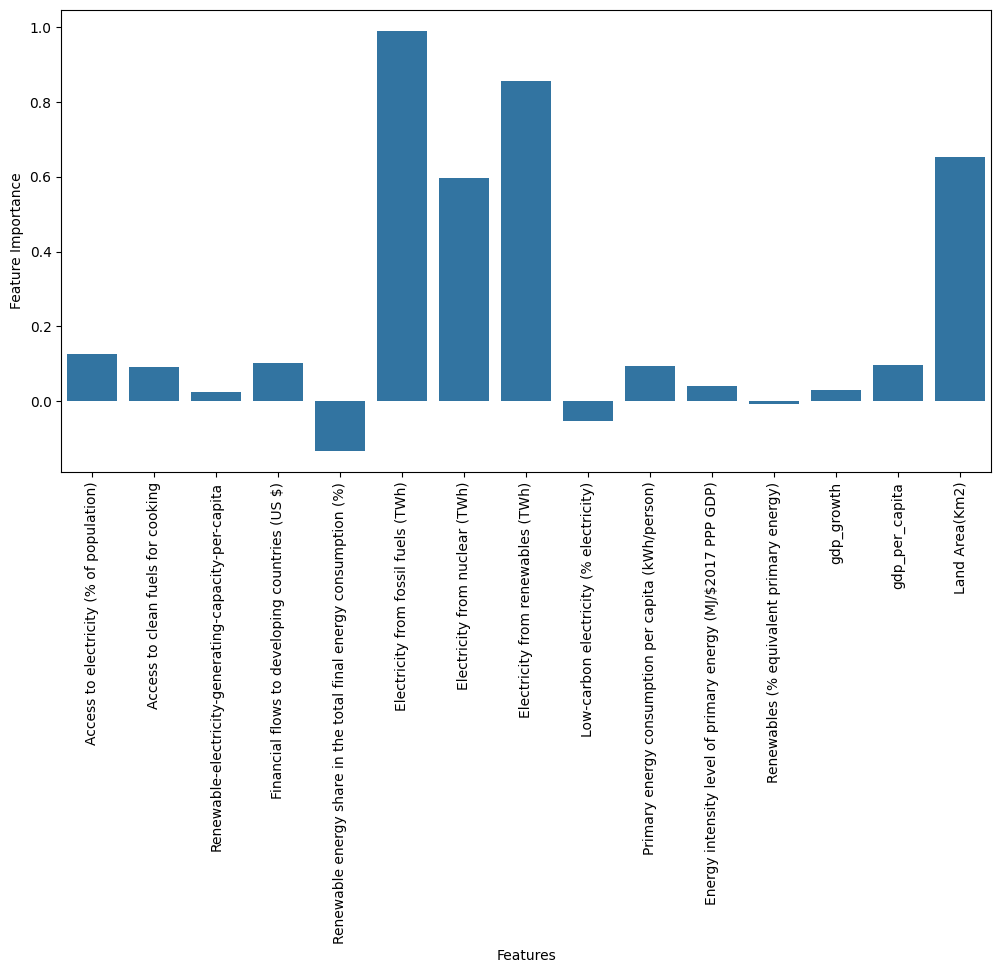

In [305]:
#identifying importance of features through SelectKBest

import seaborn as sns
import matplotlib.pyplot as plt

skb = SelectKBest(r_regression, k=5)

X = imputed_data.drop(["Value_co2_emissions_kt_by_country", "Entity", "Year"], axis=1)

y = imputed_data["Value_co2_emissions_kt_by_country"]

skb.fit_transform(X, y)

feature_indices = skb.get_support(indices=True)

feature_importance = skb.scores_

plt.figure(figsize=(12, 6))
plt.ylabel("Feature Importance")
plt.xlabel("Features")
sns.barplot(x=X.columns, y=feature_importance)
plt.xticks(rotation=90, fontsize=10)


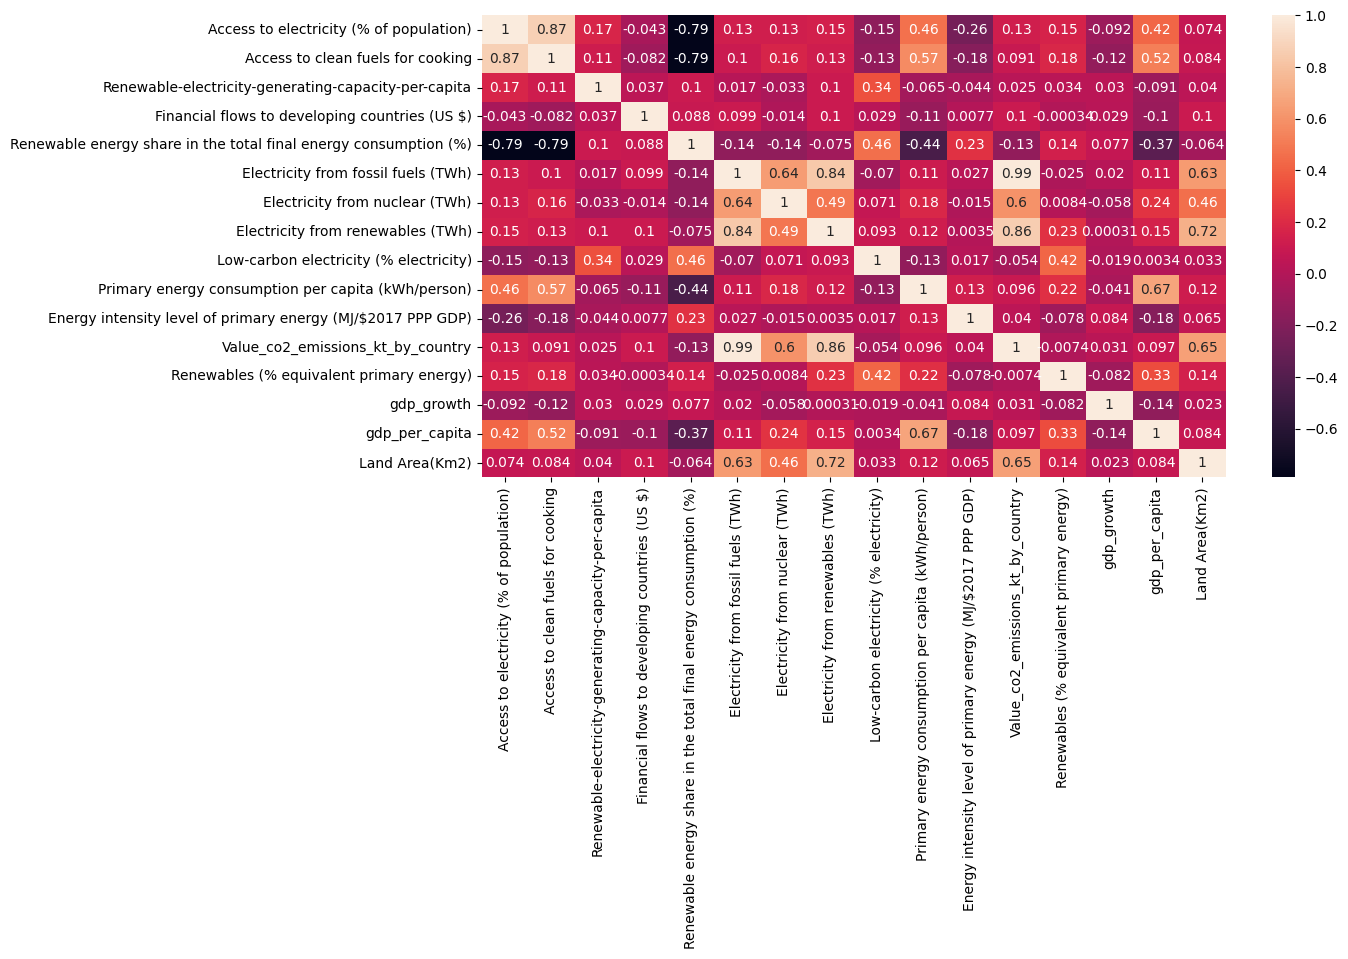

In [306]:
#Heat map for correlation matrix

corr = imputed_data.drop(["Entity", "Year"], axis=1).corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True)
plt.xticks(rotation=90, fontsize=10)
plt.show()

In [307]:
# Find the best amount of features to use with respect to mean absolute error

from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

def best_reg(reg, name):

    amount_of_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

    y = imputed_data['Value_co2_emissions_kt_by_country']
    
    errors = []
    corr_feature_names = []
    temp_data = imputed_data.copy(deep=True)

    for k in amount_of_features:

        feature_names, X_new = feature_selection_k_means(k, temp_data.copy(deep=True))

        X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

        curr_mae = float('inf')

        if name in ["LassoCV", "RidgeCV"]:
            lcv = reg(cv=5)
            lcv.fit(X_train, y_train)
            y_pred = lcv.predict(X_test)
            curr_mae = min(curr_mae, mean_absolute_error(y_test, y_pred))
            
        else: #Random Forest Regression
            lcv = reg()
            lcv.fit(X_train, y_train)
            y_pred = lcv.predict(X_test)
            curr_mae = min(curr_mae, mean_absolute_error(y_test, y_pred))


        errors.append(curr_mae)
        corr_feature_names.append(feature_names)

    best_mae = min(errors)
    print(f"Best Features for {name}:")
    for feature in corr_feature_names[errors.index(best_mae)]:
        print(feature)

    print(f"{name} mae: {best_mae}")
    print("\n")
    return (best_mae, name)


In [308]:
lcv_mae, lcv = best_reg(LassoCV, "lassoCV")
rcv_mae, rcv = best_reg(RidgeCV, "RidgeCV")
rfr_mae, rfr = best_reg(RandomForestRegressor, "Random Forest Regressor")

# finds the best model in respect to mean absolute error and the best amount of features in respect to each regression
best_reg = min(lcv_mae, min(rcv_mae,rfr_mae))

Best Features for lassoCV:
Electricity from fossil fuels (TWh)
Electricity from renewables (TWh)
lassoCV mae: 27175.688956893562


Best Features for RidgeCV:
Electricity from fossil fuels (TWh)
Electricity from renewables (TWh)
RidgeCV mae: 27431.50169476943


Best Features for Random Forest Regressor:
Electricity from fossil fuels (TWh)
Electricity from renewables (TWh)
Land Area(Km2)
Random Forest Regressor mae: 10355.659529145116




In [309]:
#concluded that RandomForestRegressor was the best model.

#hyperparameter tuning RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 2, 5, 10],
}

feature_names, X_new = feature_selection_k_means(6, imputed_data.copy(deep=True))

y = imputed_data['Value_co2_emissions_kt_by_country']

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

rfr = RandomForestRegressor()

random_search = RandomizedSearchCV(
    rfr,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

Best parameters: {'n_estimators': 150, 'max_depth': 10}


In [310]:
#accuracy of RandomForestRegressor after hyperparameter tuning

from sklearn.metrics import r2_score

rfr = RandomForestRegressor(n_estimators=150, max_depth=10)

rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

print(f"r2 score for RandomForestRegressor : {r2_score(y_test, y_pred)}")


r2 score for RandomForestRegressor : 0.9935718648858631


In [311]:
#hyperparameter tuning LassoCV

param_grid = {
    'tol': [0.1, 0.001, 0.0001, 0.00001],
}

feature_names, X_new = feature_selection_k_means(2, imputed_data.copy())

y = imputed_data['Value_co2_emissions_kt_by_country']

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

lcv = LassoCV()

random_search = RandomizedSearchCV(
    lcv,
    param_distributions=param_grid,
    n_iter=4,
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

Best parameters: {'tol': 1e-05}


In [312]:
#accuracy of LassoCV after hyperparameter tuning

from sklearn.metrics import r2_score

lcv = LassoCV(cv=5,tol=1e-05)
lcv.fit(X_train, y_train)
y_pred = lcv.predict(X_test)

print(f"r2 score for LassoCV : {r2_score(y_test, y_pred)}")

r2 score for LassoCV : 0.9806625551343409


In [313]:
#hyperparameter tuning RidgeCV

param_grid = {
    'alphas': [1, 0.1, 0.001, 0.0001, 0.00001],
}

feature_names, X_new = feature_selection_k_means(2, imputed_data.copy())

y = imputed_data['Value_co2_emissions_kt_by_country']

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

rcv = RidgeCV()

random_search = RandomizedSearchCV(
    rcv,
    param_distributions=param_grid,
    n_iter=4,
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

Best parameters: {'alphas': 1}


In [314]:
#accuracy of RidgeCV after hyperparameter tuning

from sklearn.metrics import r2_score

rcv = RidgeCV(cv=5,alphas=[1])
rcv.fit(X_train, y_train)
y_pred = rcv.predict(X_test)

print(f"r2 score for RidgeCV : {r2_score(y_test, y_pred)}")

r2 score for RidgeCV : 0.980508045910855


In [315]:
#find most accurate country with respect to LassoCV

countries = np.array(list(set(imputed_data["Entity"])))


country_and_r2score_and_df = []

y_pred_and_y_test = []

for country in countries:
    feature_names, X_new = feature_selection_k_means(2, imputed_data.copy())

    df = imputed_data[imputed_data["Entity"] == country]

    X = df[feature_names]

    #add Year Column
    X["Year"] = df["Year"]

    y = df["Value_co2_emissions_kt_by_country"]

    #Default amount of records required
    if len(X) > 10:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

        lcv = LassoCV(cv=5, tol=1e-05)

        lcv.fit(X_train, y_train)
        
        y_pred = lcv.predict(X_test)

        country_and_r2score_and_df.append((country, r2_score(y_test, y_pred), X_test))
        y_pred_and_y_test.append((y_pred, y_test))
    
#Find most accurate country and corresponding data frame and r2 score
maxr2 = 0
most_accurate_country = None
corr_df = None
for country, r2score, curr_df in country_and_r2score_and_df:
    if maxr2 < r2score:
        maxr2 = r2score
        most_accurate_country = country
        corr_df = curr_df
print(f"best r2 score: {maxr2}")
print(f"most accurate country for LassoCV: {most_accurate_country}")


best r2 score: 0.9939774988335277
most accurate country for LassoCV: China


most accurate prediction for LassoCV: China
r2 score: 0.9939774988335277


<module 'matplotlib.pyplot' from '/home/floo/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

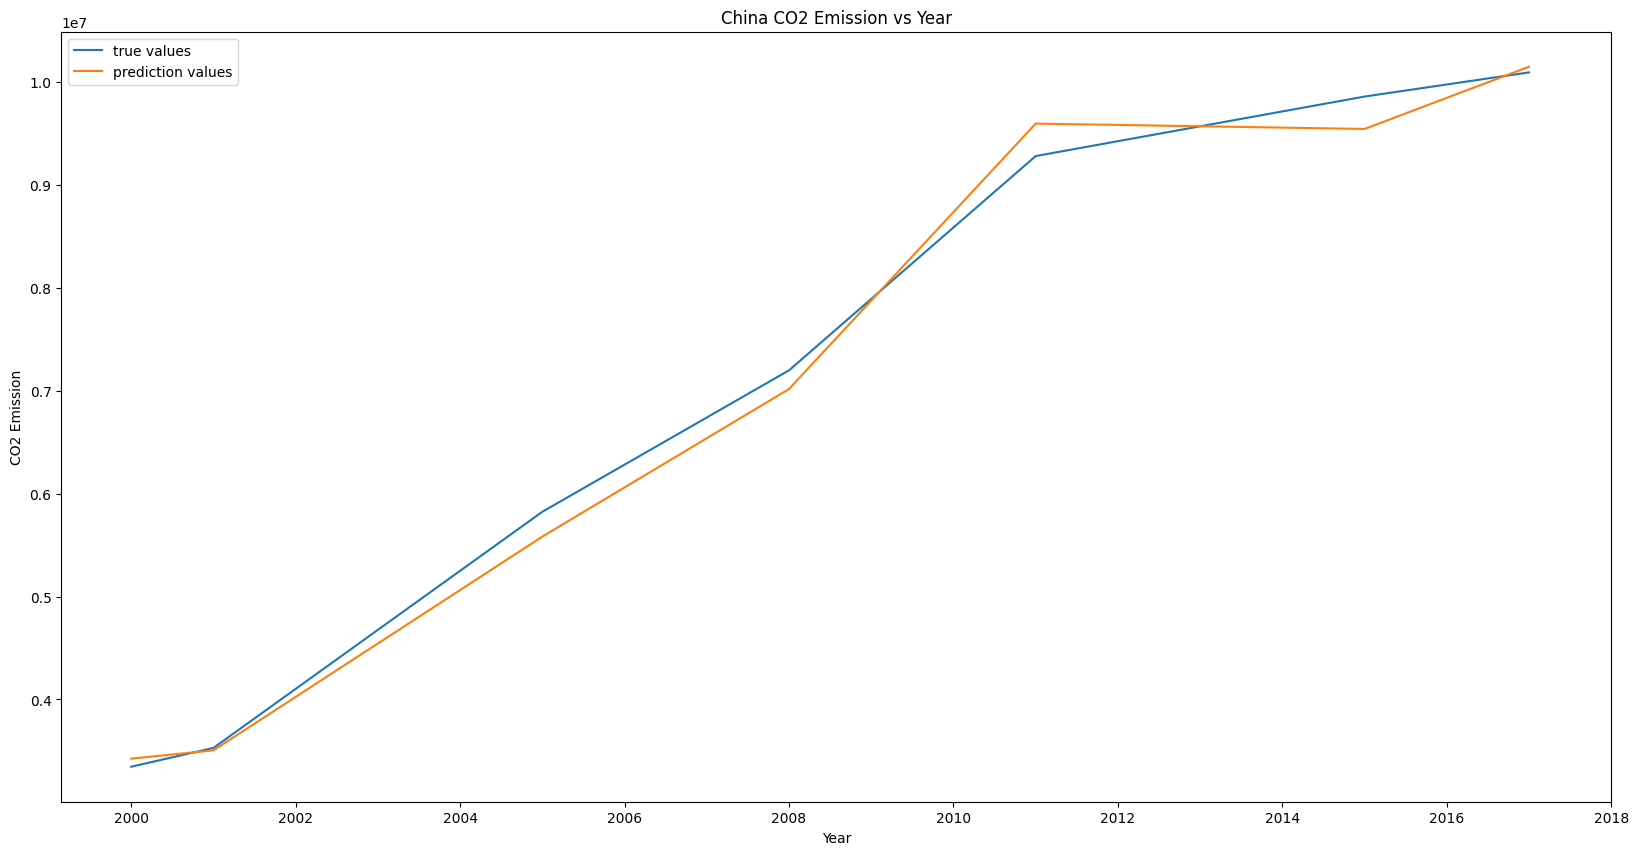

In [316]:
#Visualization of LassoCV
import matplotlib.pyplot as plt

print(f"most accurate prediction for LassoCV: {most_accurate_country}")
print(f"r2 score: {maxr2}")

index = country_and_r2score_and_df.index((most_accurate_country, maxr2, corr_df))

#grab corresponding predictions and true labels
y_pred, y_test = y_pred_and_y_test[index]

corr_df['y_pred'] = y_pred
corr_df['y_test'] = y_test

#sort by year for easier plotting
corr_df_sorted = corr_df.sort_values(by='Year')


plt.figure(figsize=(20, 10))
plt.plot(corr_df_sorted["Year"], corr_df_sorted["y_test"], label="true values")
plt.plot(corr_df_sorted["Year"], corr_df_sorted["y_pred"], label="prediction values")
plt.xticks(range(2000, 2020, 2))
plt.title("China CO2 Emission vs Year")
plt.xlabel("Year")
plt.ylabel("CO2 Emission")
plt.legend()
plt


In [317]:
#Find most accurate country with respect to RidgeCV

countries = np.array(list(set(imputed_data["Entity"])))


country_and_r2score_and_df = []

y_pred_and_y_test = []

for country in countries:
    feature_names, X_new = feature_selection_k_means(2, imputed_data.copy())

    df = imputed_data[imputed_data["Entity"] == country]

    X = df[feature_names]

    #add year to column
    X["Year"] = df["Year"]

    y = df["Value_co2_emissions_kt_by_country"]

    #Default amount of records required
    if len(X) > 10:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        rcv = RidgeCV(cv=5, alphas=[1])
        rcv.fit(X_train, y_train)
        y_pred = rcv.predict(X_test)

        country_and_r2score_and_df.append((country, r2_score(y_test, y_pred), X_test))
        y_pred_and_y_test.append((y_pred, y_test))
    
#find most accurate predictions for a country with respect to RidgeCV
maxr2 = 0
most_accurate_country = None
corr_df = None
for country, r2score, curr_df in country_and_r2score_and_df:
    if maxr2 < r2score:
        maxr2 = r2score
        most_accurate_country = country
        corr_df = curr_df

print(f"best r2 score: {maxr2}")
print(f"most accurate country for LassoCV: {most_accurate_country}")


best r2 score: 0.9941928268299807
most accurate country for LassoCV: Bahrain


most accurate prediction: Bahrain
r2score: 0.9941928268299807


<module 'matplotlib.pyplot' from '/home/floo/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

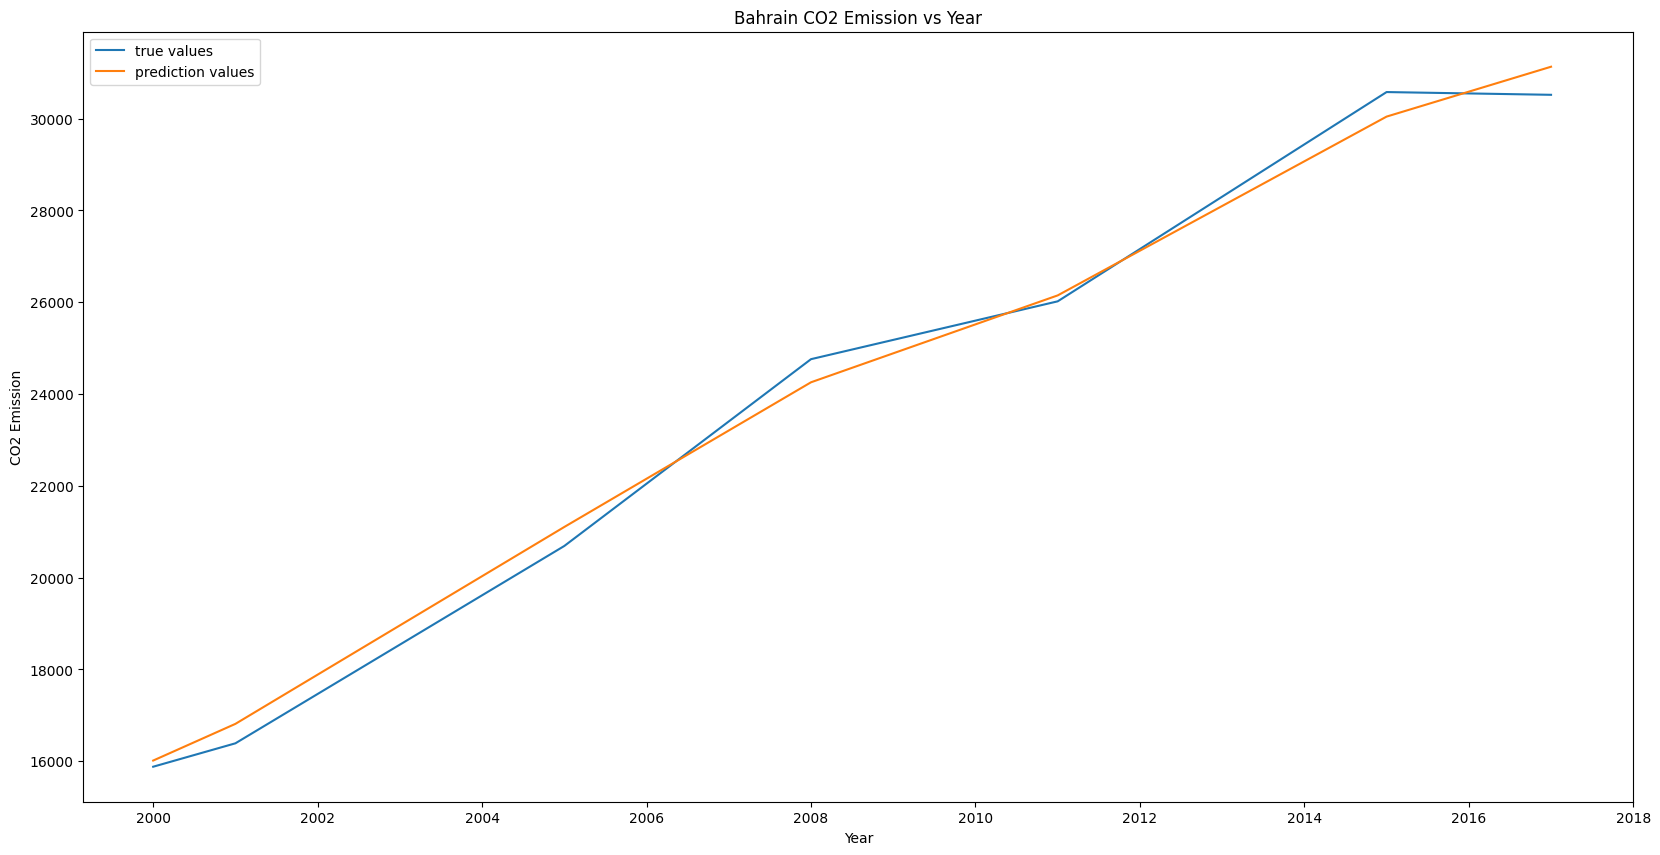

In [318]:
#Visualization of RidgeCV
import matplotlib.pyplot as plt

print(f"most accurate prediction: {most_accurate_country}")
print(f"r2score: {maxr2}")

index = country_and_r2score_and_df.index((most_accurate_country, maxr2, corr_df))

y_pred, y_test = y_pred_and_y_test[index]

corr_df['y_pred'] = y_pred
corr_df['y_test'] = y_test

#sort by year for easier plotting
corr_df_sorted = corr_df.sort_values(by='Year')


plt.figure(figsize=(20, 10))
plt.plot(corr_df_sorted["Year"], corr_df_sorted["y_test"], label="true values")
plt.plot(corr_df_sorted["Year"], corr_df_sorted["y_pred"], label="prediction values")
plt.title("Bahrain CO2 Emission vs Year")
plt.xlabel("Year")
plt.ylabel("CO2 Emission")
plt.xticks(range(2000, 2020, 2))
plt.legend()
plt

In [319]:
#find most accurate country with respect to RandomForestRegressor

countries = np.array(list(set(imputed_data["Entity"])))


country_and_r2score_and_df = []

y_pred_and_y_test = []

for country in countries:
    feature_names, X_new = feature_selection_k_means(9, imputed_data.copy())

    df = imputed_data[imputed_data["Entity"] == country]

    X = df[feature_names]

    #add year column
    X["Year"] = df["Year"]

    y = df["Value_co2_emissions_kt_by_country"]

    #default amount of records required
    if len(X) > 10:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        rfr = RandomForestRegressor()
        rfr.fit(X_train, y_train)
        y_pred = rfr.predict(X_test)

        country_and_r2score_and_df.append((country, r2_score(y_test, y_pred), X_test))
        y_pred_and_y_test.append((y_pred, y_test))
    
#find most accurate predictions for a country with respect to RandomForestRegressor
maxr2 = 0
most_accurate_country = None
corr_df = None
for country, r2score, curr_df in country_and_r2score_and_df:
    if maxr2 < r2score:
        maxr2 = r2score
        most_accurate_country = country
        corr_df = curr_df

print(f"best r2 score: {maxr2}")
print(f"most accurate country for LassoCV: {most_accurate_country}")

best r2 score: 0.9960160730869693
most accurate country for LassoCV: Cambodia


most accurate prediction: Cambodia
r2score: 0.9960160730869693


<module 'matplotlib.pyplot' from '/home/floo/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

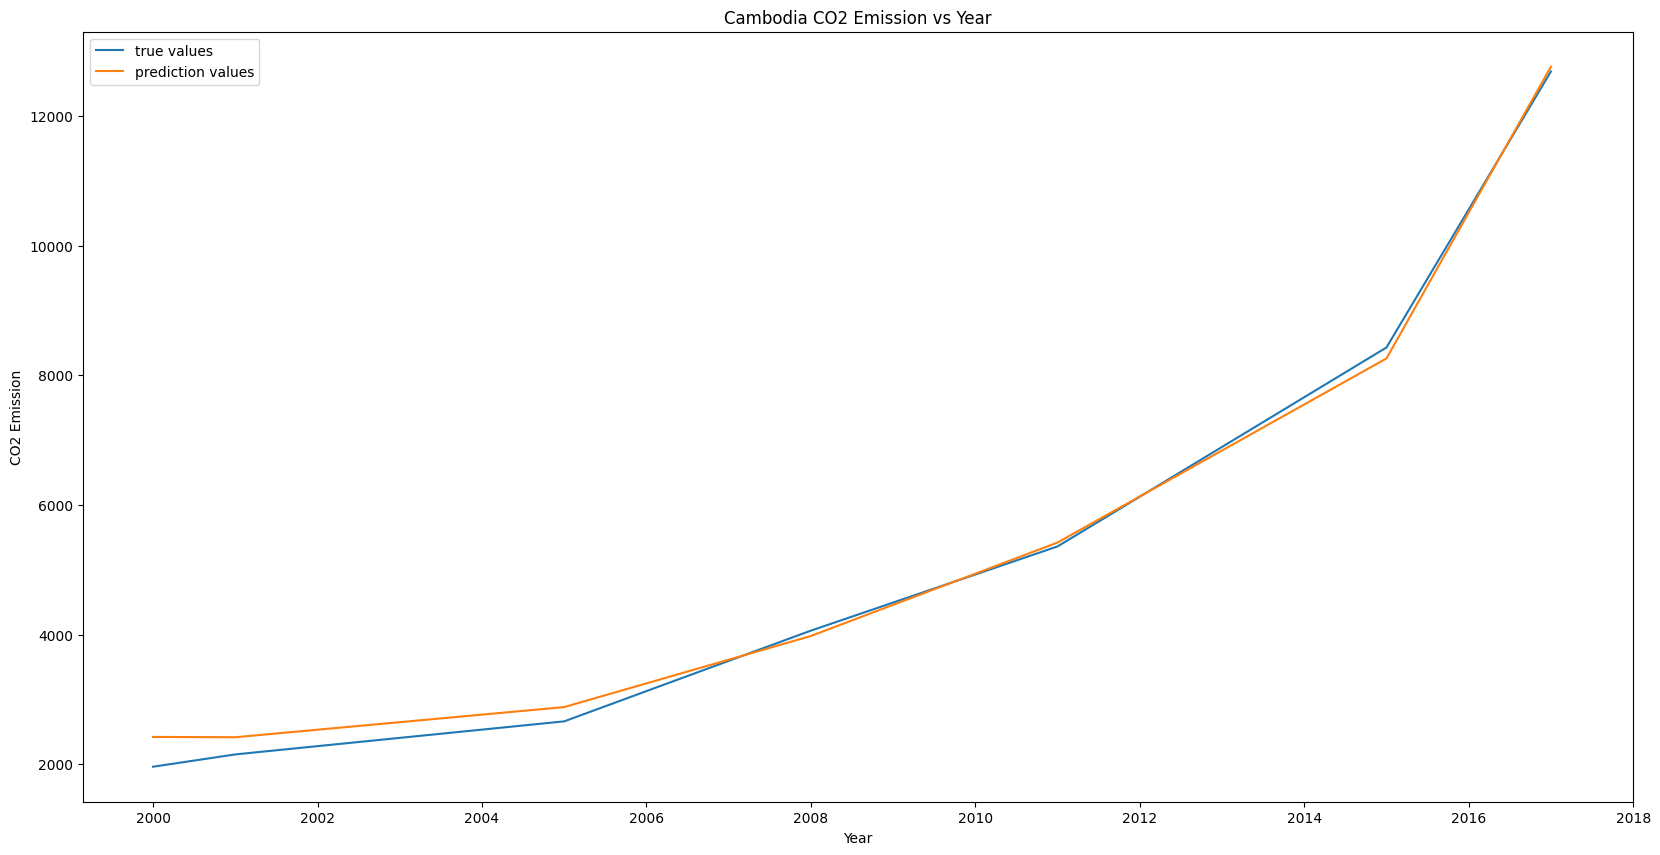

In [320]:
#Visualization of RandomForestRegressor
import matplotlib.pyplot as plt

print(f"most accurate prediction: {most_accurate_country}")
print(f"r2score: {maxr2}")

index = country_and_r2score_and_df.index((most_accurate_country, maxr2, corr_df))

y_pred, y_test = y_pred_and_y_test[index]

corr_df['y_pred'] = y_pred
corr_df['y_test'] = y_test

corr_df_sorted = corr_df.sort_values(by='Year')

plt.figure(figsize=(20, 10))
plt.plot(corr_df_sorted["Year"], corr_df_sorted["y_test"], label="true values")
plt.plot(corr_df_sorted["Year"], corr_df_sorted["y_pred"], label="prediction values")
plt.title("Cambodia CO2 Emission vs Year")
plt.xlabel("Year")
plt.ylabel("CO2 Emission")
plt.xticks(range(2000, 2020, 2))
plt.legend()
plt

For LassoCV, RidgeCV, and RandomForestRegressor I applied feature selection and hyperparameter tuning to obtain the most accuracy in respect to the model. After doing so I searched for the country that the model best predicted and plotted the truth and prediction labels to visually represented the accuracy. After doing so, I would also find the accuracy in respect to the r2 score for each model. From this experiment, we were able to conclude that RandomForestRegressor was the best model for predicting CO2 Emission per country compared to the other models. Overall, each regression model performed quite well, which is natural as regression models are meant to predict continuous variables, which in this case CO2 Emission is a continuous variable within the dataset.

In [321]:
#ARIMA Model for predicting future values up to 2023 with respect to China
from statsmodels.tsa.arima.model import ARIMA

train_data = imputed_data[imputed_data["Entity"] == "China"][0: int(len(imputed_data[imputed_data["Entity"] == "China"])*0.7)]
test_data = imputed_data[imputed_data["Entity"] == "China"][int(len(imputed_data[imputed_data["Entity"] == "China"])*0.7):]

train_arima = train_data['Value_co2_emissions_kt_by_country']
test_arima = test_data['Value_co2_emissions_kt_by_country']


test_arima.reset_index(drop=True, inplace=True)

history = [x for x in train_arima]
predictions = []

#Main loop for forecasting
for i in range(len(test_arima)):
    arima = ARIMA(history, order=(1, 1, 0))

    arima_fit = arima.fit()

    y_pred = arima_fit.forecast()[0]
    
    predictions.append(y_pred)

    history.append(test_arima[i])

print(f"mean absolute error for ARIMA Model: {mean_absolute_error(test_arima, predictions)}")
predictions = predictions + (arima_fit.predict(start = 18, end=21).tolist())




mean absolute error for ARIMA Model: 160106.5000377257


24


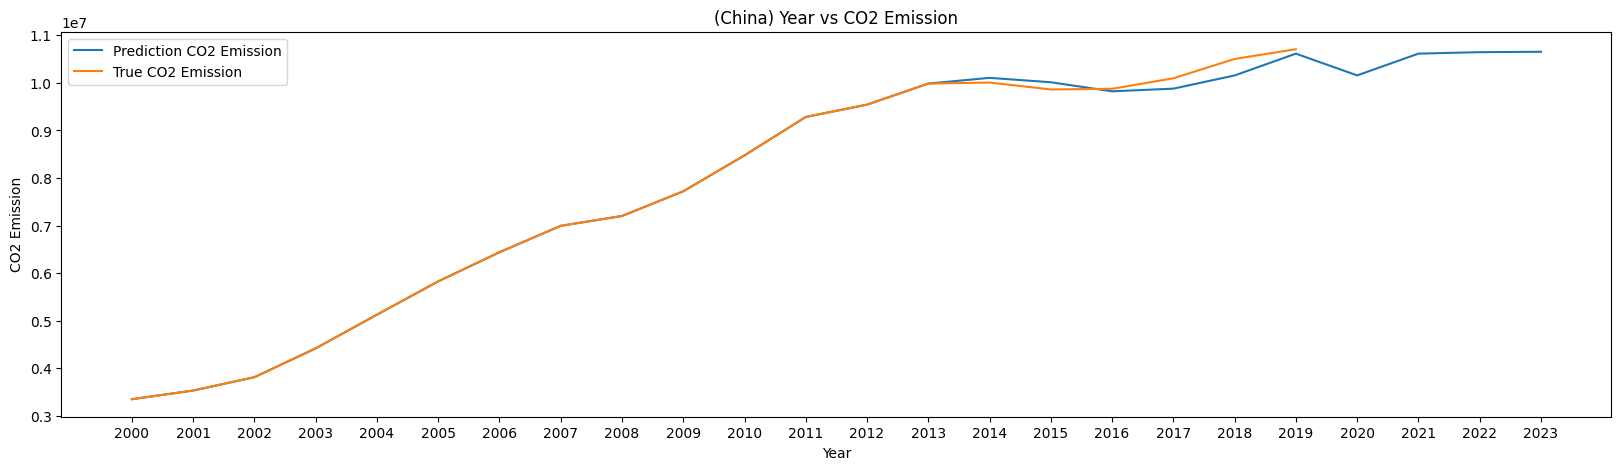

In [322]:
#Visualization of the ARIMA Model and its future forecasts with respect to China

time = train_arima.tolist() + predictions
x = range(24)
print(len(time))
plt.figure(figsize=(20,5))
plt.plot(time)
plt.xticks(x, [str(2000 + i) for i in range(24)])
plt.title("(China) Year vs CO2 Emission")
plt.ylabel("CO2 Emission")
plt.xlabel("Year")
plt.plot(train_arima.tolist() + test_arima.tolist())
plt.legend(["Prediction CO2 Emission", "True CO2 Emission"])

lowerbound: -0.0076155344840328236
upperbound: 0.013263201004610238


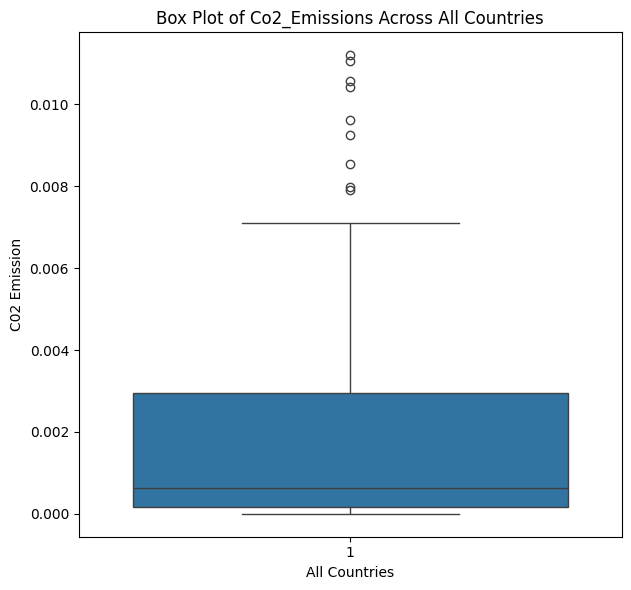

In [323]:
#Creating IQR BoxPlot for Visual Representation of the mean of CO2 emissions per country

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

#Normalization
scalar = MinMaxScaler()

#First we must aggregate the data

#Remove year as we don't want to normalize this column
agg_data = imputed_data.drop('Year',axis=1)

#Only grab numerical columns
num_cols = agg_data.select_dtypes(include=['number'])

#obtain column names
num_cols_labels = list(num_cols.columns)

agg_data[num_cols_labels] = scalar.fit_transform(imputed_data.drop(["Entity", "Year"], axis=1))

# aggreggating the data Frame with respect to the mean of each country
agg_data = agg_data.groupby("Entity")["Value_co2_emissions_kt_by_country"].mean().reset_index()

#Obtain the 25th and 75th Quantile
Q1 = agg_data["Value_co2_emissions_kt_by_country"].quantile(0.25)
Q3 = agg_data["Value_co2_emissions_kt_by_country"].quantile(0.75)

#Calculate the IQR
IQR = Q3 - Q1

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

print(f"lowerbound: {lower_bound}")
print(f"upperbound: {upper_bound}")

lower_bound_cond = (agg_data["Value_co2_emissions_kt_by_country"] >= lower_bound)
upper_bound_cond = (agg_data["Value_co2_emissions_kt_by_country"] <= upper_bound)

filtered_data = agg_data["Value_co2_emissions_kt_by_country"][lower_bound_cond & upper_bound_cond]

plt.figure(figsize=(12, 6))
y = filtered_data
x = 1
plt.subplot(1, 2, 1)
sns.boxplot(x=x, y=y)
plt.title('Box Plot of Co2_Emissions Across All Countries')
plt.xlabel("All Countries")
plt.ylabel("C02 Emission")
plt.tight_layout()
plt.show()

In [324]:
#Normalization
scalar = MinMaxScaler()

agg_data = imputed_data.drop('Year',axis=1)

num_cols = agg_data.select_dtypes(include=['number'])

num_cols_labels = list(num_cols.columns)

agg_data[num_cols_labels] = scalar.fit_transform(imputed_data.drop(["Entity", "Year"], axis=1))

#Threshold to determine if the amount of CO2 emission is high or low
threshold = np.percentile(agg_data["Value_co2_emissions_kt_by_country"], 50)

cond = [
    agg_data["Value_co2_emissions_kt_by_country"] <= threshold,
    agg_data["Value_co2_emissions_kt_by_country"] > threshold,
]

# 0 : low CO2 Emission
# 1 : high CO2 Emission
labels = [0, 1]

#one hot encoding CO2 emissions based on threshold
agg_data['co2_category'] = np.select(cond, labels)

Created an aggregated data frame that contains the new column `co2_category`. This column is one-hot encoded determines if the CO2 emitted in that country during that Year was considered high or low. This was determined by assigning a threshold obtained from the 2nd quartile.

In [325]:
#obtain countries that have both labels at one point in time

import numpy as np

countries = set(agg_data["Entity"])
two_label_countries = []

for country in countries:
    agg_data[(agg_data["Entity"]) == country]["co2_category"]
    if (len(np.unique(agg_data[(agg_data["Entity"]) == country]["co2_category"])) > 1):
        two_label_countries.append(country)

two_label_countries

['Jamaica',
 'Myanmar',
 'Guatemala',
 'Senegal',
 'Cambodia',
 'Kenya',
 'Luxembourg',
 'Mongolia',
 'Nepal',
 'Estonia',
 'Ethiopia',
 'Sudan',
 'Panama',
 'Trinidad and Tobago',
 'Ghana',
 'Zimbabwe']

r2 score for K-Nearest Neighbors: 0.6871945259042034, with n_neighbors = 24


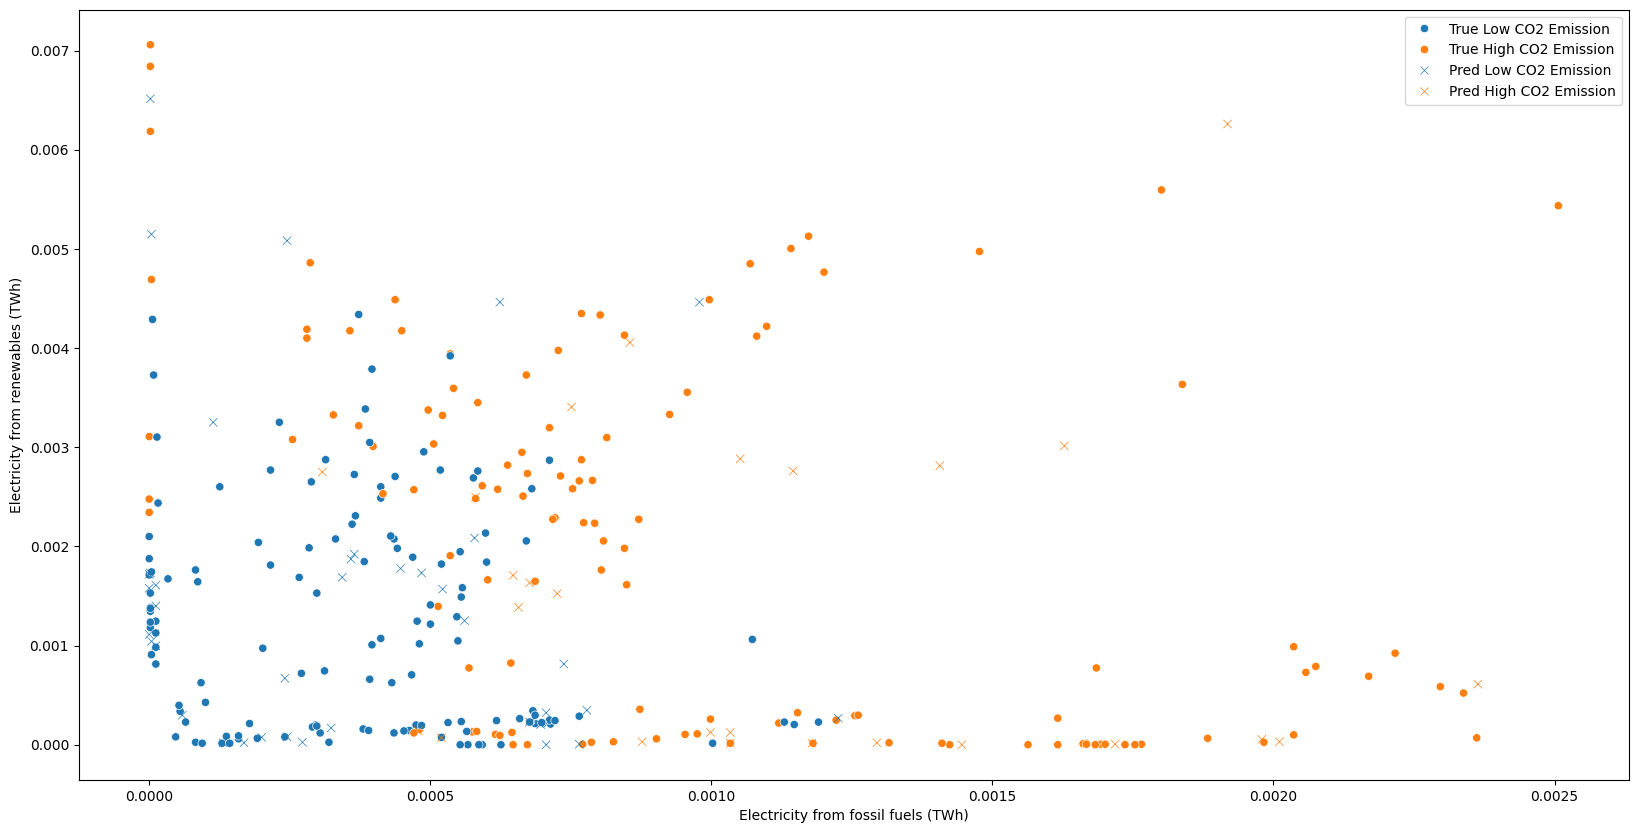

In [326]:
#Classification using K-Nearest Neighbors and plot corresponding scatterplot
from sklearn.neighbors import KNeighborsClassifier

selected_data = agg_data[agg_data["Entity"].isin(two_label_countries)]

# selected_data = selected_data[['Electricity from fossil fuels (TWh)', "Electricity from renewables (TWh)", "co2_category", "Entity"]]

X_new = selected_data.drop(["co2_category", "Entity", "Value_co2_emissions_kt_by_country"], axis=1)

y = selected_data["co2_category"]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

plt.figure(figsize=(20, 10))
scatter1 = sns.scatterplot(x=X_train["Electricity from fossil fuels (TWh)"], y=X_train["Electricity from renewables (TWh)"], hue=y_train, marker='o')


best_r2 = 0
best_nn = None
nns = [3, 5, 8, 10, 12, 14, 16, 18, 20, 22, 24]
for nn in nns:
    knn = KNeighborsClassifier(n_neighbors=nn)

    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    if best_r2 < r2_score(y_test, y_pred):
        best_r2 = r2_score(y_test, y_pred)
        best_nn = nn

print(f"r2 score for K-Nearest Neighbors: {best_r2}, with n_neighbors = {nn}")

scatter = sns.scatterplot(x=X_test["Electricity from fossil fuels (TWh)"], y=X_test["Electricity from renewables (TWh)"], hue=y_pred, marker='x')

scatter.legend_.texts[0].set_text("True Low CO2 Emission")
scatter.legend_.texts[1].set_text("True High CO2 Emission")
scatter.legend_.texts[2].set_text("Pred Low CO2 Emission")
scatter.legend_.texts[3].set_text("Pred High CO2 Emission")


In [327]:
#Classification with RandomForestClassifier with corresponding scatter plot

from sklearn.ensemble import RandomForestClassifier

selected_data = agg_data[agg_data["Entity"].isin(two_label_countries)]

# selected_data = selected_data[['Electricity from fossil fuels (TWh)', "Electricity from renewables (TWh)", "co2_category", "Entity"]]

X_new = selected_data.drop(["co2_category", "Entity", "Value_co2_emissions_kt_by_country"], axis=1)
y = selected_data["co2_category"]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

param_grid = {
    'max_depth': [None, 2, 5, 10],
    'criterion': ["gini", "entropy", "log_loss"],
    'n_estimators': [50, 100, 150, 200],    
}

clf = RandomForestClassifier()

random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_grid,
    n_iter=100,
    cv=5, 
    random_state=42,
    n_jobs=-1 
)

random_search.fit(X_train, y_train)
y_pred = random_search.predict(X_test)
print(f"r2 score for Random Forest Classifier: {r2_score(y_test, y_pred)}")
print(f"best parameters: {random_search.best_params_}")


r2 score for Random Forest Classifier: 0.7497556207233627
best parameters: {'n_estimators': 150, 'max_depth': None, 'criterion': 'gini'}


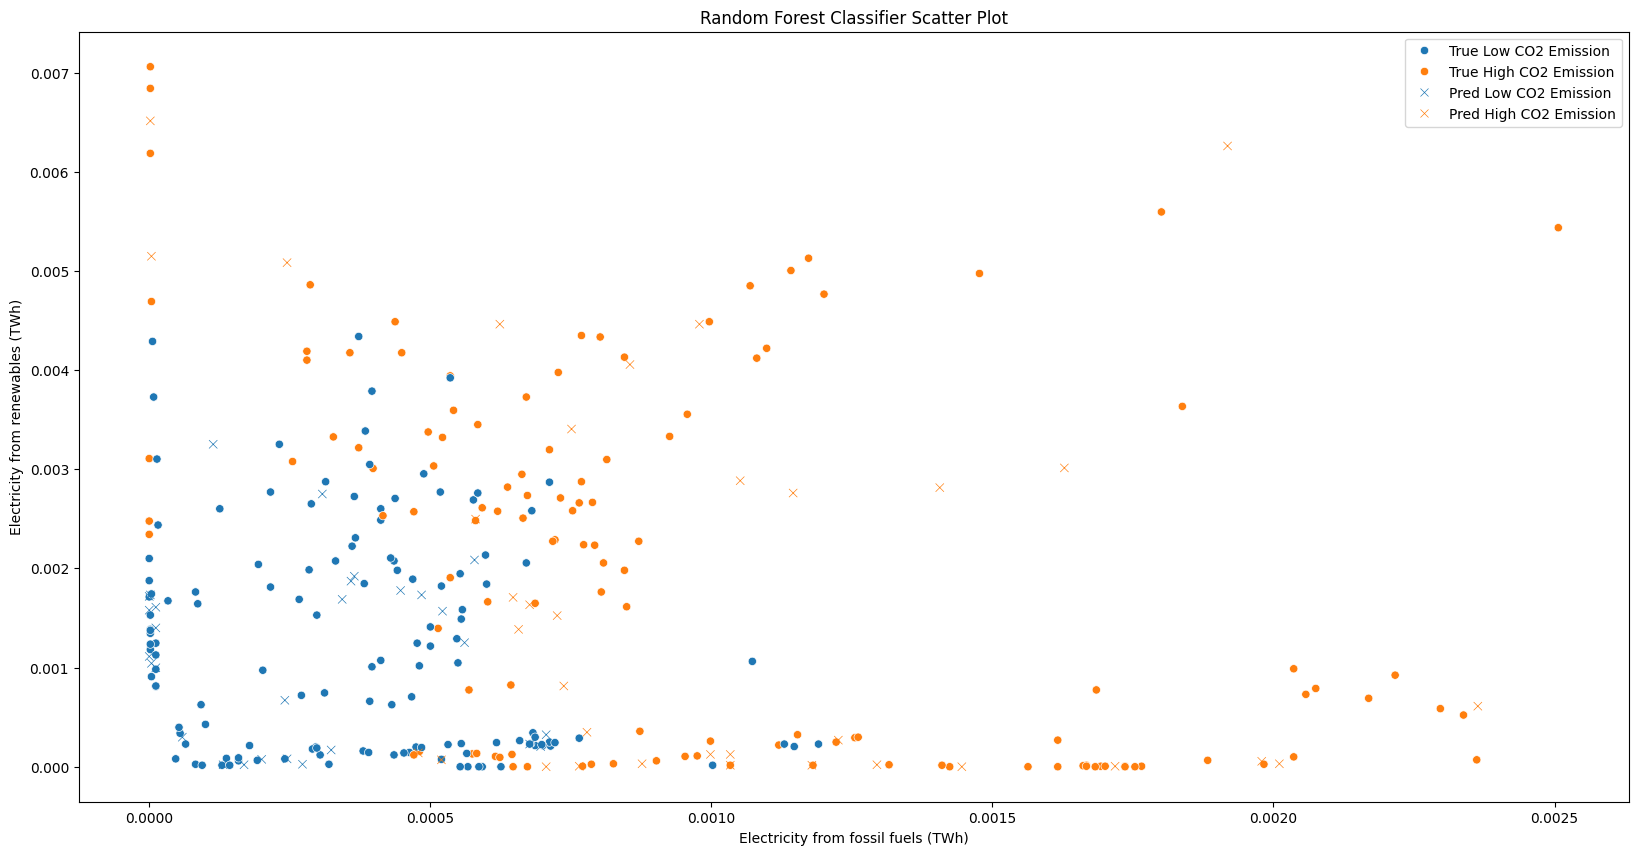

In [328]:
#Plot for Random Forest Classifier
plt.figure(figsize=(20, 10))

scatter1 = sns.scatterplot(x=X_train["Electricity from fossil fuels (TWh)"], y=X_train["Electricity from renewables (TWh)"], hue=y_train, marker='o')

scatter = sns.scatterplot(x=X_test["Electricity from fossil fuels (TWh)"], y=X_test["Electricity from renewables (TWh)"], hue=y_pred, marker='x')

plt.title("Random Forest Classifier Scatter Plot")
scatter.legend_.texts[0].set_text("True Low CO2 Emission")
scatter.legend_.texts[1].set_text("True High CO2 Emission")
scatter.legend_.texts[2].set_text("Pred Low CO2 Emission")
scatter.legend_.texts[3].set_text("Pred High CO2 Emission")